data split check value should be 72598077 (72598077)
train/val set:  (10759, 1113) ; test set:  (2690, 1113)
29.495027418905103
43.61621004398275
Counter({1: 6178, 0: 4581}) 0.42578306534064503
Counter({0: 9986, 1: 773}) 0.07184682591318896
31.640520446096655
45.15096273791262
Counter({1: 1550, 0: 1140}) 0.42379182156133827
Counter({0: 2492, 1: 198}) 0.07360594795539034
Rank all feats by RF ...


feature selection:   2%|▏         | 1/64 [00:00<00:11,  5.29it/s]

RF on all features, mean: 0.8361, std 0.0186
Select top feats by cross validation ...


feature selection: 100%|██████████| 64/64 [01:07<00:00,  1.06s/it]


Evaluation ...
topK features: 22
['age_month', 'lab_5211_min', 'lab_5227_max', 'lab_5249_min', 'lab_5235_max', 'lab_5227_min', 'lab_5237_min', 'chart_1016_min', 'chart_1001_min', 'lab_5223_max', 'lab_5226_max', 'lab_5248_min', 'chart_1004_min', 'lab_5211_max', 'chart_1001_max', 'lab_5249_max', 'lab_5224_min', 'chart_1004_max', 'lab_5129_max', 'lab_5252_min', 'lab_5127_max', 'chart_1016_max']
Final model: Probability = sigmoid(-0.0019*age_month + 0.0555*lab_5211_min + 0.0734*lab_5227_max + -0.0452*lab_5249_min + 0.0188*lab_5235_max + 0.0318*lab_5227_min + 0.0596*lab_5237_min + -0.0139*chart_1016_min + -0.0169*chart_1001_min + 0.0292*lab_5223_max + 0.0295*lab_5226_max + -0.0645*lab_5248_min + -0.0012*chart_1004_min + 0.0228*lab_5211_max + 0.0002*chart_1001_max + -0.0259*lab_5249_max + 0.0106*lab_5224_min + 0.0008*chart_1004_max + -0.0026*lab_5129_max + -0.0062*lab_5252_min + -0.2476*lab_5127_max + 0.0040*chart_1016_max + -1.5191)


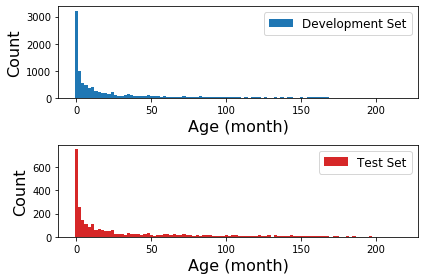

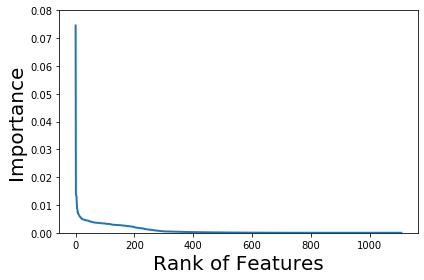

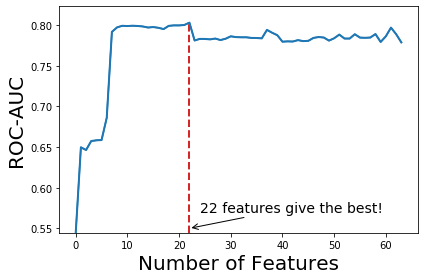

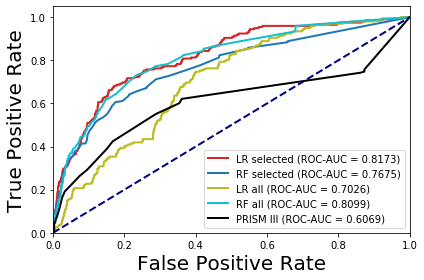

In [1]:
run exp.py